In [1]:
import chess
import concurrent.futures
import chess.pgn
import chess.engine
import random
import time
import ast
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm

In [2]:
def fen_to_vec(fen, w_elo, b_elo, w_time, b_time, inc, thres): 
    board = chess.Board(fen)
    n_moves = len(list(board.legal_moves))
    with chess.engine.SimpleEngine.popen_uci(r"C:\Users\DELL\Desktop\stockfish\stockfish-windows-x86-64-avx2\stockfish\stockfish-windows-x86-64-avx2") as engine:
        eval = str(engine.analyse(board, chess.engine.Limit(time = 0.1))['score'].white())
        vars = engine.analyse(board, chess.engine.Limit(time = 0.1), multipv = n_moves)
    if eval[0] == '#':
        eval = (eval[1] == '+')*5000 - (eval[1] == '-')*5000
    w_wins = draws = 0
    for var in vars:
        var_score = str(var['score'].white())
        if var_score[0] == '#':
            if var_score[1] == '+':
                w_wins += 1
        elif int(var_score) > thres:
            w_wins += 1
        elif -thres <= int(var_score) <= thres:
            draws += 1
    ply = board.fullmove_number*2 - board.turn
    vec = np.array([n_moves, board.turn, ply, w_elo, b_elo, w_time, b_time, inc, w_wins, draws, int(eval)])
    return vec

In [2]:
def eval_fun(fen): #returns the evaluation of all the variations
    evals = []
    moves = []
    board = chess.Board(fen)
    n_moves = len(list(board.legal_moves))
    with chess.engine.SimpleEngine.popen_uci(r"C:\Users\DELL\Desktop\stockfish\stockfish-windows-x86-64-avx2\stockfish\stockfish-windows-x86-64-avx2") as engine:
        vars = engine.analyse(board, chess.engine.Limit(time = 0.1), multipv = n_moves)
    for var in vars:
        var_score = str(var['score'].white())
        if var_score[0] == '#':
            evals.append((var_score[1] == '+')*5000 - (var_score[1] == '-')*5000)
        else:
            evals.append(int(var_score))
        moves.append(str(var['pv'][0]))  
    stock_policy = {move:eval for move, eval in zip(moves, evals)}
    return fen, stock_policy

Features to extract:
1. White ELO
2. BLack ELO
3. White clock
4. Black clock
5. Percent time difference
6. Position Evaluation
7. % White win lines
8. % Draw lines
9. Increment in seconds
10. Ply number (indicates the phase of the game)

In [4]:
# game_details = []
# # stockfish_path = r"C:\Users\DELL\Desktop\stockfish\stockfish-windows-x86-64-avx2\stockfish\stockfish-windows-x86-64-avx2"
# # engine = chess.engine.SimpleEngine.popen_uci(stockfish_path)
# for i in range(2013, 2014):
#     pgn = open(str(i) + '.pgn')
#     while 1:
#         game = chess.pgn.read_game(pgn)
#         if game is None:
#             break
#         n_plies = int(game.headers['PlyCount'])
#         if game.headers['WhiteClock'] != game.headers['BlackClock'] or n_plies < 40: #no handicap and short games, only classical & rapid games
#             continue
#         w_elo = int(game.headers['WhiteElo'])
#         b_elo = int(game.headers['BlackElo'])
#         result = game.headers['Result']
#         if result == '1-0':
#             result = 1
#         elif result == '0-1':
#             result = -1
#         else:
#             result = 0
#         total_time = int(game.headers['TimeControl'].split('+')[0]) #in seconds 
#         inc = int(game.headers['TimeControl'].split('+')[1]) #increment time in seconds
#         nums = list(range(30, n_plies))
#         random.shuffle(nums)
#         sel_plies = sorted(nums[:4])
#         k = 0
#         n = 1
#         w_time = b_time = 0 #time elapsed for each side
#         while len(game.variations):
#             if n == sel_plies[k]:
#                 b = game.board()
#                 # eval_init = str(engine.analyse(b, chess.engine.Limit(time = 0.1))['score'].white())
#                 # eval_final = str(engine.analyse(game.variations[0].board(), chess.engine.Limit(time = 0.1))['score'].white())
#                 # if eval_init[0] == '#':
#                 #     eval_init = (eval_init[1] == '+')*5000 - (eval_init[1] == '-')*5000
#                 # if eval_final[0] == '#':
#                 #     eval_final = (eval_final[1] == '+')*5000 - (eval_final[1] == '-')*5000
#                 # cp_loss = abs(int(eval_final) - int(eval_init))
#                 # % winning lines
#                 # w_win = b_win = 0
#                 # n_moves = len(list(b.legal_moves))
#                 # for move in b.legal_moves:
#                 #     b.push(move)
#                 #     move_eval = str(engine.analyse(b, chess.engine.Limit(time = 0.1))['score'].white())
#                 #     if move_eval[0] == '#':
#                 #         if move_eval[1] == '+':
#                 #             w_win += 1
#                 #         else:
#                 #             b_win += 1
#                 #     elif int(move_eval) >= 30:
#                 #         w_win += 1
#                 #     elif int(move_eval) <= -30:
#                 #         b_win += 1
#                 #     b.pop()
#                 # per_w = w_win*100/n_moves #% moves leading to white adv
#                 # per_b = b_win*100/n_moves #% moves leading to black adv
#                 # per_draw = 100 - per_w - per_b
#                 details = [b.fen(), n, w_elo, b_elo, total_time - w_time, total_time - b_time, inc, str(game.variations[0].move), result]
#                 details_str = [str(detail) for detail in details]
#                 with open('game_details_win_percent2.txt', 'a') as f:
#                     f.write('$'.join(details_str) + '\n')
#                 k += 1
#                 if k == len(sel_plies):
#                     break
#             if n % 2:
#                 w_time += float(game.variations[0].comment.split(']')[0].split(' ')[-1])
#             else:
#                 b_time += float(game.variations[0].comment.split(']')[0].split(' ')[-1])
#             game = game.variations[0]
#             n += 1

READING THE DATA FROM THE FILE

In [3]:
def num_moves(fen):
    board = chess.Board(fen)
    return len(list(board.legal_moves))

In [3]:
X = []
with open('game_details_win_percent2.txt', 'r') as f:
    for line in f:
        X.append(line.strip().split('$'))
X = np.array(X)
#X = np.concatenate(((X[:,1].astype(int)%2).reshape(-1, 1), X), axis = 1)

In [43]:
X[0]

array(['rn3r1k/pp3ppp/4p3/3p1N2/8/2NP2PP/PPP3P1/2KR3R b - - 0 17', '34',
       '2059', '1941', '663.512', '399.17199999999997', '10', 'e6f5', '1'],
      dtype='<U76')

In [7]:
fens = X[:, 1]
with concurrent.futures.ThreadPoolExecutor() as executor:
    n_moves = np.array(list(executor.map(num_moves, fens)))
X = np.concatenate((n_moves.reshape(-1, 1), X), axis = 1)

In [44]:
fens_in_file = []
with open('eval_features_win_percent_vars3.txt', 'r') as f:
    for line in f:
        fens_in_file.append(line.strip().split('$')[0])

In [63]:
fens_not_in_file = set(fens_in_file) - set(X[:, 0])
len(fens_not_in_file)

0

In [64]:
len(df2)

325019

In [9]:
#fens = X[:, 2]
fens = fens_not_in_file
#253766
#eval_features = []
with concurrent.futures.ThreadPoolExecutor() as executor:
    #eval_features = np.array(list(executor.map(aug, fens)))
    progress = tqdm(total = len(fens))
    futures = [executor.submit(eval_fun, fen) for fen in fens]
    for future in concurrent.futures.as_completed(futures):
        # Update progress bar
        result = future.result()
        with open('eval_features_win_percent_vars3.txt', 'a') as f:
            #f.write('$'.join([str(item) for item in result]) + '\n')
            f.write(result[0] + '$' + str(result[1]) + '\n')
        #eval_features.append(result)
        progress.update(1)
    progress.close()
#eval_features = np.array(eval_features)

100%|████████████████████████████████████████████████████████████████████████████| 10553/10553 [18:34<00:00,  9.47it/s]


In [4]:
df1 = pd.DataFrame(X[:, :-2])
df1.columns = ['fens', 'plies', 'w_elo', 'b_elo', 'w_time', 'b_time', 'inc_time']
df1['plies'] = df1['plies'].astype(int)
df1['w_elo'] = df1['w_elo'].astype(int)
df1['b_elo'] = df1['b_elo'].astype(int)
df1['w_time'] = df1['w_time'].astype(float)
df1['b_time'] = df1['b_time'].astype(float)
df1['inc_time'] = df1['inc_time'].astype(float)
df1['w_time'] = df1['w_time'] + df1['plies']//2*df1['inc_time']
df1['b_time'] = df1['b_time'] + (df1['plies'] - 1)//2*df1['inc_time']
df1.head(5)

,fens,plies,w_elo,b_elo,w_time,b_time,inc_time
0,rn3r1k/pp3ppp/4p3/3p1N2/8/2NP2PP/PPP3P1/2KR3R ...,34,2059,1941,833.512,559.172,10.0
1,3r3k/1p3ppp/p1n1r3/3N1p2/1PP5/P2P2PP/3K2P1/4R2...,46,2059,1941,781.438,483.189,10.0
2,4k3/1p6/p5pp/3p1p2/1PP4P/P1K3P1/6P1/8 w - - 0 34,67,2059,1941,702.540,307.390,10.0
3,8/1p6/p2k2pp/3P1p2/PP5P/2K3P1/6P1/8 w - - 1 36,71,2059,1941,684.551,316.295,10.0
4,r2q1rk1/1pp1b1pp/2np4/p7/2Pp4/P4BPP/1P1BQP2/4R...,36,2743,2319,602.324,790.941,0.0


In [5]:
fens_eval = []
evals = []
with open('eval_features_win_percent_vars3.txt', 'r') as f:
    for line in f:
        res = line.strip().split('$')
        fens_eval.append(res[0])
        evals.append(res[1])

In [6]:
df2 = pd.DataFrame({'fens':fens_eval, 'stock_evals':evals})
df2 = df2.drop_duplicates(subset = ['fens'])
df2.head(5)

,fens,stock_evals
0,r4rk1/2p2ppp/p1b1p3/1p1n4/1P1PN2q/PQ1BP3/5PPK/...,{'h2g1': 248}
1,1k3b1r/1q5p/p3R3/4Q2P/1P6/P7/5PPK/2r5 b - - 1 32,"{'b7c7': -544, 'b8a8': -182, 'b8c8': -156, 'b8..."
2,r1bn2k1/ppp2pp1/5n1p/3PN3/q1P5/B2B4/P2Q1PPP/4R...,"{'a3e7': 468, 'a3c5': 408, 'e1e3': 393, 'd2c3'..."
3,4k3/1p6/p5pp/3p1p2/1PP4P/P1K3P1/6P1/8 w - - 0 34,"{'c4d5': 206, 'c3d4': 131, 'c3d3': 130, 'a3a4'..."
4,2b4r/6pp/pk3p2/1pb1P3/2p2P2/r1n2NP1/3N2BP/R3R2...,"{'a1c1': -406, 'd2c4': -418, 'a1a3': -444, 'e5..."


In [7]:
df_merged = df1.merge(df2, on = 'fens', how = 'left')
df_merged.head(5)

,fens,plies,w_elo,b_elo,w_time,b_time,inc_time,stock_evals
0,rn3r1k/pp3ppp/4p3/3p1N2/8/2NP2PP/PPP3P1/2KR3R ...,34,2059,1941,833.512,559.172,10.0,"{'e6f5': 239, 'h8g8': 458, 'b8c6': 476, 'h7h6'..."
1,3r3k/1p3ppp/p1n1r3/3N1p2/1PP5/P2P2PP/3K2P1/4R2...,46,2059,1941,781.438,483.189,10.0,"{'g7g5': 232, 'h8g8': 253, 'b7b5': 254, 'g7g6'..."
2,4k3/1p6/p5pp/3p1p2/1PP4P/P1K3P1/6P1/8 w - - 0 34,67,2059,1941,702.540,307.390,10.0,"{'c4d5': 206, 'c3d4': 131, 'c3d3': 130, 'a3a4'..."
3,8/1p6/p2k2pp/3P1p2/PP5P/2K3P1/6P1/8 w - - 1 36,71,2059,1941,684.551,316.295,10.0,"{'c3c4': 284, 'h4h5': 283, 'c3d4': 229, 'g3g4'..."
4,r2q1rk1/1pp1b1pp/2np4/p7/2Pp4/P4BPP/1P1BQP2/4R...,36,2743,2319,602.324,790.941,0.0,"{'e7f6': 34, 'f8e8': 72, 'e7g5': 82, 'f8f3': 1..."


In [108]:
df_save = df_merged.iloc[:, :8]
df_save['result'] = df_merged['result']
df_save.head(5)

,fens,plies,w_elo,b_elo,w_time,b_time,inc_time,stock_evals,result
0,rn3r1k/pp3ppp/4p3/3p1N2/8/2NP2PP/PPP3P1/2KR3R ...,34,2059,1941,833.512,559.172,10.0,"{'e6f5': 239, 'h8g8': 458, 'b8c6': 476, 'h7h6'...",1
1,3r3k/1p3ppp/p1n1r3/3N1p2/1PP5/P2P2PP/3K2P1/4R2...,46,2059,1941,781.438,483.189,10.0,"{'g7g5': 232, 'h8g8': 253, 'b7b5': 254, 'g7g6'...",1
2,4k3/1p6/p5pp/3p1p2/1PP4P/P1K3P1/6P1/8 w - - 0 34,67,2059,1941,702.540,307.390,10.0,"{'c4d5': 206, 'c3d4': 131, 'c3d3': 130, 'a3a4'...",1
3,8/1p6/p2k2pp/3P1p2/PP5P/2K3P1/6P1/8 w - - 1 36,71,2059,1941,684.551,316.295,10.0,"{'c3c4': 284, 'h4h5': 283, 'c3d4': 229, 'g3g4'...",1
4,r2q1rk1/1pp1b1pp/2np4/p7/2Pp4/P4BPP/1P1BQP2/4R...,36,2743,2319,602.324,790.941,0.0,"{'e7f6': 34, 'f8e8': 72, 'e7g5': 82, 'f8f3': 1...",1


In [109]:
df_save.to_csv('game_data_final_win_loss.csv', index = False)

In [8]:
w_plus_all = []
b_plus_all = []
equals_all = []
pos_evals = []
thres = 50
stock_evals = df_merged['stock_evals'].values
for multi_eval in stock_evals:
    stock_policy = ast.literal_eval(multi_eval)
    pos_evals.append(list(stock_policy.values())[0])
    w_plus = b_plus = equals = 0
    for eval in stock_policy.values():
        if eval > thres:
            w_plus += 1
        elif eval < -thres:
            b_plus += 1
        else:
            equals += 1
    w_plus_all.append(w_plus)
    b_plus_all.append(b_plus)
    equals_all.append(equals)

In [9]:
df_merged['white_plus'] = w_plus_all
df_merged['black_plus'] = b_plus_all
df_merged['equals'] = equals_all
df_merged['pos_evals'] = pos_evals
df_merged['result'] = X[:, -1].astype(int)
df_merged.head(5)

,fens,plies,w_elo,b_elo,w_time,b_time,inc_time,stock_evals,white_plus,black_plus,equals,pos_evals,result
0,rn3r1k/pp3ppp/4p3/3p1N2/8/2NP2PP/PPP3P1/2KR3R ...,34,2059,1941,833.512,559.172,10.0,"{'e6f5': 239, 'h8g8': 458, 'b8c6': 476, 'h7h6'...",20,0,0,239,1
1,3r3k/1p3ppp/p1n1r3/3N1p2/1PP5/P2P2PP/3K2P1/4R2...,46,2059,1941,781.438,483.189,10.0,"{'g7g5': 232, 'h8g8': 253, 'b7b5': 254, 'g7g6'...",37,0,0,232,1
2,4k3/1p6/p5pp/3p1p2/1PP4P/P1K3P1/6P1/8 w - - 0 34,67,2059,1941,702.540,307.390,10.0,"{'c4d5': 206, 'c3d4': 131, 'c3d3': 130, 'a3a4'...",7,3,2,206,1
3,8/1p6/p2k2pp/3P1p2/PP5P/2K3P1/6P1/8 w - - 1 36,71,2059,1941,684.551,316.295,10.0,"{'c3c4': 284, 'h4h5': 283, 'c3d4': 229, 'g3g4'...",3,5,3,284,1
4,r2q1rk1/1pp1b1pp/2np4/p7/2Pp4/P4BPP/1P1BQP2/4R...,36,2743,2319,602.324,790.941,0.0,"{'e7f6': 34, 'f8e8': 72, 'e7g5': 82, 'f8f3': 1...",31,0,1,34,1


In [117]:
eval_features = []
thres = 80
with open('eval_features_win_percent_vars.txt', 'r') as f:
    for line in f:
        stock_policy = ast.literal_eval(line.strip())
        w_wins = draws = 0
        for eval in stock_policy.values():
            if eval > thres:
                w_wins += 1
            elif -thres <= eval <= thres:
                draws += 1
        eval_features.append([w_wins, draws])#, list(stock_policy.values())[0]])
eval_features = np.array(eval_features)
evals = []
with open('eval_features_win_percent.txt', 'r') as f:
    for line in f:
        evals.append(int(line.strip()))
eval_features = np.concatenate((eval_features, np.array(evals).reshape(-1, 1)), axis = 1)

In [101]:
X[0]

array(['20', '0',
       'rn3r1k/pp3ppp/4p3/3p1N2/8/2NP2PP/PPP3P1/2KR3R b - - 0 17', '34',
       '2059', '1941', '663.512', '399.17199999999997', '10', 'e6f5', '1'],
      dtype='<U76')

In [10]:
Y = X[:, -1].astype(int)
ohe = OneHotEncoder(sparse_output = False)
Y_ohe = ohe.fit_transform(Y.reshape(-1, 1))
print(ohe.categories_)

[array([-1,  0,  1])]


In [11]:
X_final = df_merged.iloc[:, [1, 2, 3, 4, 5, 6, 8, 9, 10, 11]].values
X_final[0]

array([  34.   , 2059.   , 1941.   ,  833.512,  559.172,   10.   ,
         20.   ,    0.   ,    0.   ,  239.   ])

In [12]:
# eval_features = []
# with open('eval_features_win_percent.txt', 'r') as f:
#     for line in f:
#         eval_features.append(int(line.strip()))
# eval_features = np.array(eval_features)

In [118]:
# X = np.concatenate((np.array([[float(Xij) for Xij in Xi[[0, 1, 3, 4, 5, 6, 7, 8]]] for Xi in X]), eval_features.reshape(-1,1)), axis = 1)
X_final = np.concatenate((np.array([[float(Xij) for Xij in Xi[[0, 1, 3, 4, 5, 6, 7, 8]]] for Xi in X]), eval_features), axis = 1)

In [103]:
X_final[1]

array([  37.   ,    0.   ,   46.   , 2059.   , 1941.   ,  551.438,
        263.189,   10.   ,    0.   ,    0.   ,   16.   ])

In [112]:
x_train, x_test_val, y_train, y_test_val = train_test_split(X_final, Y_ohe, test_size = 0.3, shuffle = True, random_state = 0)
x_val, x_test, y_val, y_test = train_test_split(x_test_val, y_test_val, test_size = 0.6)

In [114]:
evals = []
models = []
scores = []
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 5)
with open('eval_features_win_percent.txt', 'r') as f:
    for line in f:
        evals.append(int(line.strip()))
for thres in range(50, 100, 10):
    eval_features = []
    with open('eval_features_win_percent_vars.txt', 'r') as f:
        for line in f:
            stock_policy = ast.literal_eval(line.strip())
            w_wins = draws = 0
            for eval in stock_policy.values():
                if eval > thres:
                    w_wins += 1
                elif -thres <= eval <= thres:
                    draws += 1
            eval_features.append([w_wins, draws])#, list(stock_policy.values())[0]])
    eval_features = np.concatenate((np.array(eval_features), np.array(evals).reshape(-1, 1)), axis = 1)
    X_final = np.concatenate((np.array([[float(Xij) for Xij in Xi[[0, 1, 3, 4, 5, 6, 7, 8]]] for Xi in X]), eval_features), axis = 1)
    x_train, x_test_val, y_train, y_test_val = train_test_split(X_final, Y_ohe, test_size = 0.3, shuffle = True, random_state = 0)
    x_val, x_test, y_val, y_test = train_test_split(x_test_val, y_test_val, test_size = 0.6)
    ni = len(X[0])
    no = len(Y_ohe[0])
    # best 192 2 layers, accuracy test = 73.22%
    model = Sequential([
        Dense(256, input_shape = (ni,), activation = 'relu'),
        #Dropout(0.1),
        Dense(256, activation = 'relu'),
        #Dropout(0.1),
        #Dense(192, activation = 'relu'),
        Dense(no, activation = 'softmax')
    ])
    model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
    )
    model.fit(x_train, y_train, epochs = 50, validation_data = (x_val, y_val), batch_size = 32, callbacks = [early_stopping_callback], verbose = 0)
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred, axis = 1) - 1
    y_true = ohe.inverse_transform(y_test).reshape(-1)
    score = accuracy_score(y_true, y_pred)*100
    print(f'The test score for threshold = {thres} is {score}%.')
    scores.append(score)
    models.append(model)
    del model
print(f'The best threshold = {50 + 10*np.argmax(scores)} with accuracy {max(scores)}%')

1831/1831 [==============================] - 3s 1ms/step
The test score for threshold = 50 is 73.39787920700783%.
1831/1831 [==============================] - 2s 910us/step
The test score for threshold = 60 is 72.51165411608011%.
1831/1831 [==============================] - 2s 933us/step
The test score for threshold = 70 is 72.36480371565665%.
1831/1831 [==============================] - 2s 904us/step
The test score for threshold = 80 is 74.15945221385516%.
1831/1831 [==============================] - 2s 1ms/step
The test score for threshold = 90 is 72.76608097262776%.
The best threshold = 80 with accuracy 74.15945221385516%


BUILDING THE MODEL WIN DRAW LOSS MODEL

In [121]:
!pip install lazypredict

   ---------------------------------------- 0.0/97.9 kB ? eta -:--:--
   ------------ --------------------------- 30.7/97.9 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 97.9/97.9 kB 1.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   --- ------------------------------------ 0.1/1.3 MB 2.7 MB/s eta 0:00:01
   ----------- ---------------------------- 0.4/1.3 MB 4.1 MB/s eta 0:00:01
   ------------------ --------------------- 0.6/1.3 MB 4.2 MB/s eta 0:00:01
   -------------------------- ------------- 0.9/1.3 MB 4.7 MB/s eta 0:00:01
   ----------------------------------- ---- 1.2/1.3 MB 5.1 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3 MB 4.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.3/99.8 MB 5.7 MB/s eta 0:00:18
   ---------------------------------------- 0.5/99.8 MB 6.8 MB/s eta 0:00:15
   ----------------------

In [12]:
from lazypredict.Supervised import LazyClassifier
x_train_clf, x_test_val_clf, y_train_clf, y_test_val_clf = train_test_split(X_final, Y, test_size = 0.3, shuffle = True, random_state = 0)
x_val_clf, x_test_clf, y_val_clf, y_test_clf = train_test_split(x_test_val_clf, y_test_val_clf, test_size = 0.6)
clf = LazyClassifier(verbose = 1, ignore_warnings = False, custom_metric = None)
models, predictions = clf.fit(x_train_clf, x_test_clf, y_train_clf, y_test_clf)
print(predictions)

  3%|██▊                                                                                | 1/29 [00:23<11:03, 23.69s/it]

ROC AUC couldn't be calculated for AdaBoostClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'AdaBoostClassifier', 'Accuracy': 0.7797073237368304, 'Balanced Accuracy': 0.7234676415453513, 'ROC AUC': None, 'F1 Score': 0.776341919973614, 'Time taken': 23.694534063339233}


  7%|█████▋                                                                             | 2/29 [01:06<15:35, 34.67s/it]

ROC AUC couldn't be calculated for BaggingClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'BaggingClassifier', 'Accuracy': 0.7916773389341393, 'Balanced Accuracy': 0.7415573845430696, 'ROC AUC': None, 'F1 Score': 0.7894867020979209, 'Time taken': 42.34608554840088}


 10%|████████▌                                                                          | 3/29 [01:06<08:14, 19.02s/it]

ROC AUC couldn't be calculated for BernoulliNB
multi_class must be in ('ovo', 'ovr')
{'Model': 'BernoulliNB', 'Accuracy': 0.7061967453853115, 'Balanced Accuracy': 0.6593228660099827, 'ROC AUC': None, 'F1 Score': 0.7103586627035139, 'Time taken': 0.41121935844421387}


 17%|██████████████▎                                                                    | 5/29 [01:19<04:17, 10.73s/it]

ROC AUC couldn't be calculated for CalibratedClassifierCV
multi_class must be in ('ovo', 'ovr')
{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.7667810733739733, 'Balanced Accuracy': 0.6738011828656001, 'ROC AUC': None, 'F1 Score': 0.751042525815461, 'Time taken': 13.075644254684448}
CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


 21%|█████████████████▏                                                                 | 6/29 [01:25<03:27,  9.01s/it]

ROC AUC couldn't be calculated for DecisionTreeClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.7349350272356265, 'Balanced Accuracy': 0.6874927233158318, 'ROC AUC': None, 'F1 Score': 0.7353394339940929, 'Time taken': 5.683655738830566}


 24%|████████████████████                                                               | 7/29 [01:25<02:15,  6.16s/it]

ROC AUC couldn't be calculated for DummyClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'DummyClassifier', 'Accuracy': 0.437836176425388, 'Balanced Accuracy': 0.3333333333333333, 'ROC AUC': None, 'F1 Score': 0.266651403727219, 'Time taken': 0.26815152168273926}


 28%|██████████████████████▉                                                            | 8/29 [01:26<01:32,  4.43s/it]

ROC AUC couldn't be calculated for ExtraTreeClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'ExtraTreeClassifier', 'Accuracy': 0.6937315369772723, 'Balanced Accuracy': 0.643070460841422, 'ROC AUC': None, 'F1 Score': 0.6940786507131547, 'Time taken': 0.7255733013153076}


 31%|█████████████████████████▊                                                         | 9/29 [02:19<06:29, 19.49s/it]

ROC AUC couldn't be calculated for ExtraTreesClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'ExtraTreesClassifier', 'Accuracy': 0.800266379796117, 'Balanced Accuracy': 0.7441342348244189, 'ROC AUC': None, 'F1 Score': 0.7961969675356716, 'Time taken': 52.61172699928284}


 34%|████████████████████████████▎                                                     | 10/29 [02:19<04:18, 13.59s/it]

ROC AUC couldn't be calculated for GaussianNB
multi_class must be in ('ovo', 'ovr')
{'Model': 'GaussianNB', 'Accuracy': 0.650017929409354, 'Balanced Accuracy': 0.6488834741442103, 'ROC AUC': None, 'F1 Score': 0.660595575337928, 'Time taken': 0.3785889148712158}


 41%|█████████████████████████████████▉                                                | 12/29 [03:01<04:22, 15.45s/it]

ROC AUC couldn't be calculated for KNeighborsClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'KNeighborsClassifier', 'Accuracy': 0.7520618820757133, 'Balanced Accuracy': 0.697455158794627, 'ROC AUC': None, 'F1 Score': 0.7499539626351179, 'Time taken': 41.504844665527344}
LabelPropagation model failed to execute
Unable to allocate 386. GiB for an array with shape (227743, 227743) and data type float64


 45%|████████████████████████████████████▊                                             | 13/29 [03:01<02:53, 10.84s/it]

LabelSpreading model failed to execute
Unable to allocate 386. GiB for an array with shape (227743, 227743) and data type float64


 48%|███████████████████████████████████████▌                                          | 14/29 [03:01<01:56,  7.75s/it]

ROC AUC couldn't be calculated for LinearDiscriminantAnalysis
multi_class must be in ('ovo', 'ovr')
{'Model': 'LinearDiscriminantAnalysis', 'Accuracy': 0.7147857862472893, 'Balanced Accuracy': 0.6531699791975866, 'ROC AUC': None, 'F1 Score': 0.7113885758281734, 'Time taken': 0.5987772941589355}


 52%|██████████████████████████████████████████▍                                       | 15/29 [05:38<12:17, 52.65s/it]

ROC AUC couldn't be calculated for LinearSVC
multi_class must be in ('ovo', 'ovr')
{'Model': 'LinearSVC', 'Accuracy': 0.7671908884449226, 'Balanced Accuracy': 0.6684594140524611, 'ROC AUC': None, 'F1 Score': 0.7484965578977846, 'Time taken': 156.70554280281067}


 55%|█████████████████████████████████████████████▏                                    | 16/29 [05:40<08:05, 37.38s/it]

ROC AUC couldn't be calculated for LogisticRegression
multi_class must be in ('ovo', 'ovr')
{'Model': 'LogisticRegression', 'Accuracy': 0.7761385174939809, 'Balanced Accuracy': 0.697514586134218, 'ROC AUC': None, 'F1 Score': 0.7660382224124099, 'Time taken': 1.9388518333435059}


 59%|████████████████████████████████████████████████                                  | 17/29 [05:41<05:15, 26.31s/it]

ROC AUC couldn't be calculated for NearestCentroid
multi_class must be in ('ovo', 'ovr')
{'Model': 'NearestCentroid', 'Accuracy': 0.6472175264245342, 'Balanced Accuracy': 0.645095405008493, 'ROC AUC': None, 'F1 Score': 0.6600323227818914, 'Time taken': 0.5494742393493652}


 62%|███████████████████████████████████████████████▏                            | 18/29 [1:29:02<4:38:52, 1521.15s/it]

ROC AUC couldn't be calculated for NuSVC
multi_class must be in ('ovo', 'ovr')
{'Model': 'NuSVC', 'Accuracy': 0.7516862182606765, 'Balanced Accuracy': 0.6658363366952325, 'ROC AUC': None, 'F1 Score': 0.7391498195053947, 'Time taken': 5000.998917341232}


 66%|█████████████████████████████████████████████████▊                          | 19/29 [1:29:03<2:57:26, 1064.67s/it]

ROC AUC couldn't be calculated for PassiveAggressiveClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'PassiveAggressiveClassifier', 'Accuracy': 0.668493758857982, 'Balanced Accuracy': 0.5606539937010284, 'ROC AUC': None, 'F1 Score': 0.6400926501769773, 'Time taken': 1.259993553161621}


 69%|█████████████████████████████████████████████████████                        | 20/29 [1:29:04<1:51:48, 745.38s/it]

ROC AUC couldn't be calculated for Perceptron
multi_class must be in ('ovo', 'ovr')
{'Model': 'Perceptron', 'Accuracy': 0.7177227942557588, 'Balanced Accuracy': 0.6563135583329857, 'ROC AUC': None, 'F1 Score': 0.716965938865139, 'Time taken': 1.2106142044067383}


 72%|███████████████████████████████████████████████████████▊                     | 21/29 [1:29:05<1:09:34, 521.77s/it]

ROC AUC couldn't be calculated for QuadraticDiscriminantAnalysis
multi_class must be in ('ovo', 'ovr')
{'Model': 'QuadraticDiscriminantAnalysis', 'Accuracy': 0.6753923125522941, 'Balanced Accuracy': 0.678178775607201, 'ROC AUC': None, 'F1 Score': 0.6878630111870763, 'Time taken': 0.45676350593566895}


 76%|███████████████████████████████████████████████████████████▉                   | 22/29 [1:31:09<46:58, 402.62s/it]

ROC AUC couldn't be calculated for RandomForestClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'RandomForestClassifier', 'Accuracy': 0.8035790516196233, 'Balanced Accuracy': 0.7505539761470232, 'ROC AUC': None, 'F1 Score': 0.8003303625515842, 'Time taken': 124.75207781791687}


 79%|██████████████████████████████████████████████████████████████▋                | 23/29 [1:31:10<28:11, 281.94s/it]

ROC AUC couldn't be calculated for RidgeClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'RidgeClassifier', 'Accuracy': 0.7202158359373666, 'Balanced Accuracy': 0.6262692238356861, 'ROC AUC': None, 'F1 Score': 0.7028663332231581, 'Time taken': 0.45229434967041016}


 83%|█████████████████████████████████████████████████████████████████▍             | 24/29 [1:31:10<16:27, 197.54s/it]

ROC AUC couldn't be calculated for RidgeClassifierCV
multi_class must be in ('ovo', 'ovr')
{'Model': 'RidgeClassifierCV', 'Accuracy': 0.7201987603094103, 'Balanced Accuracy': 0.6262550225178037, 'ROC AUC': None, 'F1 Score': 0.7028498963957281, 'Time taken': 0.6678049564361572}


 86%|████████████████████████████████████████████████████████████████████           | 25/29 [1:31:12<09:15, 138.82s/it]

ROC AUC couldn't be calculated for SGDClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'SGDClassifier', 'Accuracy': 0.7524375458907502, 'Balanced Accuracy': 0.6158252133763381, 'ROC AUC': None, 'F1 Score': 0.7055507380589544, 'Time taken': 1.8256816864013672}


 90%|██████████████████████████████████████████████████████████████████████▊        | 26/29 [2:09:05<38:57, 779.04s/it]

ROC AUC couldn't be calculated for SVC
multi_class must be in ('ovo', 'ovr')
{'Model': 'SVC', 'Accuracy': 0.7910796919556716, 'Balanced Accuracy': 0.733125706310778, 'ROC AUC': None, 'F1 Score': 0.7869406671495563, 'Time taken': 2272.673842191696}
StackingClassifier model failed to execute
StackingClassifier.__init__() missing 1 required positional argument: 'estimators'


 97%|████████████████████████████████████████████████████████████████████████████▎  | 28/29 [2:09:06<06:59, 419.71s/it]

XGBClassifier model failed to execute
Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got [-1  0  1]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1735
[LightGBM] [Info] Number of data points in the train set: 227743, number of used features: 10
[LightGBM] [Info] Start training from score -0.911343
[LightGBM] [Info] Start training from score -1.830111
[LightGBM] [Info] Start training from score -0.826403


100%|███████████████████████████████████████████████████████████████████████████████| 29/29 [2:09:09<00:00, 267.23s/it]

ROC AUC couldn't be calculated for LGBMClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'LGBMClassifier', 'Accuracy': 0.7982173044413708, 'Balanced Accuracy': 0.7456411422311219, 'ROC AUC': None, 'F1 Score': 0.7952775570954894, 'Time taken': 3.0547611713409424}
                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
RandomForestClassifier             0.80               0.75    None      0.80   
LGBMClassifier                     0.80               0.75    None      0.80   
ExtraTreesClassifier               0.80               0.74    None      0.80   
BaggingClassifier                  0.79               0.74    None      0.79   
SVC                                0.79               0.73    None      0.79   
AdaBoostClassifier                 0.78               0.72    None      0.78   
LogisticRegression                 0.78               0.70    None      0.77   
KNeighbo

In [2]:
data = pd.read_csv('game_data_final_win_loss.csv')
y = data['result'].values
data_x = data.iloc[:, 1:-1]

In [3]:
data_x.head(5)

,plies,w_elo,b_elo,w_time,b_time,inc_time,stock_evals
0,34,2059,1941,833.512,559.172,10.0,"{'e6f5': 239, 'h8g8': 458, 'b8c6': 476, 'h7h6'..."
1,46,2059,1941,781.438,483.189,10.0,"{'g7g5': 232, 'h8g8': 253, 'b7b5': 254, 'g7g6'..."
2,67,2059,1941,702.540,307.390,10.0,"{'c4d5': 206, 'c3d4': 131, 'c3d3': 130, 'a3a4'..."
3,71,2059,1941,684.551,316.295,10.0,"{'c3c4': 284, 'h4h5': 283, 'c3d4': 229, 'g3g4'..."
4,36,2743,2319,602.324,790.941,0.0,"{'e7f6': 34, 'f8e8': 72, 'e7g5': 82, 'f8f3': 1..."


In [4]:
w_plus_all = []
b_plus_all = []
equals_all = []
pos_evals = []
thres = 50
stock_evals = data_x['stock_evals'].values
for multi_eval in stock_evals:
    stock_policy = ast.literal_eval(multi_eval)
    pos_evals.append(list(stock_policy.values())[0])
    w_plus = b_plus = equals = 0
    for eval in stock_policy.values():
        if eval > thres:
            w_plus += 1
        elif eval < -thres:
            b_plus += 1
        else:
            equals += 1
    w_plus_all.append(w_plus)
    b_plus_all.append(b_plus)
    equals_all.append(equals)

In [16]:
data_x = data_x.iloc[:, :-1]
data_x['white_plus'] = w_plus_all
data_x['black_plus'] = b_plus_all
data_x['equals'] = equals_all
data_x['pos_evals'] = pos_evals
data_x.head(5)

,plies,w_elo,b_elo,w_time,b_time,inc_time,white_plus,black_plus,equals,pos_evals
0,34,2059,1941,833.512,559.172,10.0,20,0,0,239
1,46,2059,1941,781.438,483.189,10.0,37,0,0,232
2,67,2059,1941,702.540,307.390,10.0,7,3,2,206
3,71,2059,1941,684.551,316.295,10.0,3,5,3,284
4,36,2743,2319,602.324,790.941,0.0,31,0,1,34


In [17]:
x = data_x.values
x_train, x_test_val, y_train, y_test_val = train_test_split(x, y, test_size = 0.3, random_state = 0)
x_val, x_test, y_val, y_test = train_test_split(x_test_val, y_test_val, test_size = 0.6)

In [12]:
!pip install catboost

   ---------------------------------------- 0.0/101.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.1 MB 1.3 MB/s eta 0:01:19
   ---------------------------------------- 0.0/101.1 MB 1.3 MB/s eta 0:01:19
   ---------------------------------------- 0.1/101.1 MB 363.1 kB/s eta 0:04:39
   ---------------------------------------- 0.1/101.1 MB 416.7 kB/s eta 0:04:03
   ---------------------------------------- 0.1/101.1 MB 490.2 kB/s eta 0:03:27
   ---------------------------------------- 0.2/101.1 MB 577.4 kB/s eta 0:02:55
   ---------------------------------------- 0.2/101.1 MB 577.4 kB/s eta 0:02:55
   ---------------------------------------- 0.2/101.1 MB 512.0 kB/s eta 0:03:18
   ---------------------------------------- 0.2/101.1 MB 546.1 kB/s eta 0:03:05
   ---------------------------------------- 0.2/101.1 MB 519.9 kB/s eta 0:03:15
   ---------------------------------------- 0.3/101.1 MB 545.8

In [18]:
import catboost
from catboost import CatBoostClassifier
model_cat = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, eval_metric='Accuracy', random_seed=42, logging_level='Verbose', use_best_model=True, early_stopping_rounds=100)
model_cat.fit(x_train, y_train, eval_set = (x_val, y_val))
y_pred_cat = model_cat.predict(x_test)
print(f'The accuracy of the catboost model is: {accuracy_score(y_test, y_pred_cat)}')

0:	learn: 0.7645636	test: 0.7621280	best: 0.7621280 (0)	total: 233ms	remaining: 3m 52s
1:	learn: 0.7743158	test: 0.7710671	best: 0.7710671 (1)	total: 306ms	remaining: 2m 32s
2:	learn: 0.7764322	test: 0.7731417	best: 0.7731417 (2)	total: 371ms	remaining: 2m 3s
3:	learn: 0.7772840	test: 0.7730393	best: 0.7731417 (2)	total: 432ms	remaining: 1m 47s
4:	learn: 0.7776792	test: 0.7722197	best: 0.7731417 (2)	total: 495ms	remaining: 1m 38s
5:	learn: 0.7782720	test: 0.7735003	best: 0.7735003 (5)	total: 556ms	remaining: 1m 32s
6:	learn: 0.7790580	test: 0.7747554	best: 0.7747554 (6)	total: 616ms	remaining: 1m 27s
7:	learn: 0.7800240	test: 0.7754982	best: 0.7754982 (7)	total: 677ms	remaining: 1m 23s
8:	learn: 0.7799932	test: 0.7749091	best: 0.7754982 (7)	total: 736ms	remaining: 1m 21s
9:	learn: 0.7805289	test: 0.7751908	best: 0.7754982 (7)	total: 794ms	remaining: 1m 18s
10:	learn: 0.7816925	test: 0.7759848	best: 0.7759848 (10)	total: 851ms	remaining: 1m 16s
11:	learn: 0.7818594	test: 0.7766252	best:

In [114]:
ni = len(x_train[0])
no = len(Y_ohe[0])
alpha = 5
ns = len(x_train)
nh = int(ns/(ni + no)/alpha)
# best 192 2 layers, accuracy test = 73.22%
model = Sequential([
    Dense(192, input_shape = (ni,), activation = 'relu'),
    #Dropout(0.1),
    #Dense(400, activation = 'relu'),
    #Dropout(0.1),
    #Dense(400, activation = 'relu'),
    Dense(192, activation = 'relu'),
    Dense(no, activation = 'softmax')
])

In [115]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [116]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 5)
model.fit(x_train, y_train, epochs = 50, validation_data = (x_val, y_val), batch_size = 32, callbacks = [early_stopping_callback])

Epoch 1/50
7117/7117 [==============================] - 19s 3ms/step - loss: 3.3326 - accuracy: 0.7138 - val_loss: 0.6363 - val_accuracy: 0.7415
Epoch 2/50
7117/7117 [==============================] - 14s 2ms/step - loss: 0.5697 - accuracy: 0.7704 - val_loss: 0.5962 - val_accuracy: 0.7552
Epoch 3/50
7117/7117 [==============================] - 14s 2ms/step - loss: 0.5544 - accuracy: 0.7764 - val_loss: 0.5509 - val_accuracy: 0.7797
Epoch 4/50
7117/7117 [==============================] - 14s 2ms/step - loss: 0.5482 - accuracy: 0.7796 - val_loss: 0.5447 - val_accuracy: 0.7805
Epoch 5/50
7117/7117 [==============================] - 14s 2ms/step - loss: 0.5458 - accuracy: 0.7808 - val_loss: 0.5488 - val_accuracy: 0.7784
Epoch 6/50
7117/7117 [==============================] - 14s 2ms/step - loss: 0.5446 - accuracy: 0.7812 - val_loss: 0.5491 - val_accuracy: 0.7789
Epoch 7/50
7117/7117 [==============================] - 14s 2ms/step - loss: 0.5397 - accuracy: 0.7832 - val_loss: 0.5482 - val_ac

MODEL EVALUATION

In [117]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis = 1) - 1
y_true = ohe.inverse_transform(y_test).reshape(-1)
print(accuracy_score(y_true, y_pred)*100)
confusion_matrix(y_true, y_pred)

1831/1831 [==============================] - 3s 2ms/step
78.41469870054472


array([[18436,  2466,  2641],
       [ 1407,  5710,  2237],
       [ 1632,  2258, 21776]], dtype=int64)

COMPARISON WITH STOCKFISH EVALUATIONS ONLY MODEL

In [125]:
bd = 50 #equality threshold
y_pred_stock = np.array([it > bd for it in x_test[:, -1]]).astype(int) - np.array([it < -bd for it in x_test[:, -1]]).astype(int)
y_true = ohe.inverse_transform(y_test).reshape(-1)
print(accuracy_score(y_true, y_pred_stock)*100)
confusion_matrix(y_true, y_pred_stock)

63.68184689991975


array([[14482,  4395,  4611],
       [ 1750,  5035,  2614],
       [ 3552,  4347, 17777]], dtype=int64)

In [119]:
model.save('best_win_loss_model_final2.h5')

C:\Users\DELL\anaconda3\envs\ddp\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RUNNING AN ENTRY

In [9]:
model = tf.keras.models.load_model('best_win_loss_model_var.keras')

In [10]:
samp_fen = 'r2r4/pq4bk/4Q1pp/1PP2p2/RB2p3/3p2NP/5PK1/3R4 b - - 3 29'
w_elo = 2647
b_elo = 2704
inc = 2
w_time = 12
b_time = 13
thres = 0.8
vec = fen_to_vec(samp_fen, w_elo, b_elo, w_time, b_time, inc, thres)
print(vec)
#model.predict(vec.reshape(-1, 1))

[  39    0   58 2647 2704   12   13    2   38    0  -17]


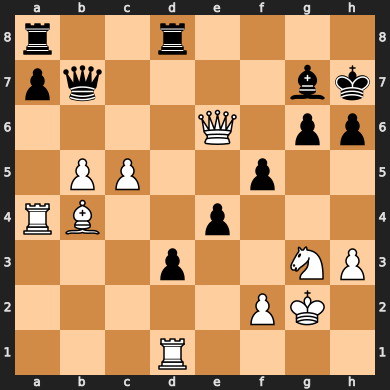

In [11]:
b_samp = chess.Board(samp_fen)
display(b_samp)

In [12]:
model.predict(np.array([vec]))

1/1 [==============================] - 0s 127ms/step


array([[0.2847922, 0.2996958, 0.415512 ]], dtype=float32)